### Project 7 : Passenger Satisfaction on SBB (Swiss Federal Railways)

    1. Define a scientific question (e.g. are women better in math?)
     
    2. Simulator. What are the dependencies? How can we modify it so we get different answers? (e.g in one simulator math ability is independent of gender; in another, it depends on educational stimulus, which depends on gender).

    3. Data sources, if any. Data collection methodology, if any. (Otherwise rely on the simulation)
    
    4. Pipeline. How do you process data reliably?
    
    5. Methodology. What machine learning / statistical methods are you using to answer the question? How do you justify them?
    
    6. Summary results: plots, graphs, tables, that can help you answer the question you are interested in.
    
    7. Conclusion based on your results. Can you answer the question? If not, why not?


### Sources intéressantes

- Influence du genre sur le salaire: https://www.ebg.admin.ch/fr/les-raisons-des-ecarts-salariaux-entre-les-femmes-et-les-hommes

- Salaires Moyens : https://www.bfs.admin.ch/bfs/fr/home/statistiques/travail-remuneration/salaires-revenus-cout-travail.html
- Durée : https://www.bfs.admin.ch/bfs/fr/home/statistiques/mobilite-transports/transport-personnes/comportements-transports/distance-duree-jour-deplacements.html
- Fréquence : https://www.bav.admin.ch/bav/fr/home/modes-de-transport/chemin-de-fer/transport-des-voyageurs.html
- Propreté :https://www.bav.admin.ch/bav/fr/home/themes-generaux/trv/systeme-de-mesure-de-la-qualite.html (je trouve inutile de l'ajouter, car la proprété est globalement très bonne en Suisse)


### TODO:
 - Changer les relations entre les variables afin d'avoir des résultats différents (Simplifier mon implémentation)
 - Faire un graph des changements
 - Essayer Knn et MLP

# **But :**
Notre objectif est de développer un modèle de classification qui prédit si un passager est satisfait ou insatisfait, en fonction de différents critères liés aux services des CFF.

# **Variables choisies :**
Les variables que nous avons sélectionnées incluent des aspects comme :

* Surpopulation (Overcrowding)  
* Prix des billets (Price)
* Ponctualité (Punctuality)
* Durée du voyage (Duration)
* Fréquence des trajets (Frequency)
* Revenu (Income)
* Possession d’une voiture (Has Car)
* Genre (Gender)
* Nombre de jours de télétravail (Remote Working Days)
* Âge (Age)

### Graph dependecies

### Data generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GenerativeModel import ImpactOnOvercrowding

In [28]:
# Generation of synthetic data
np.random.seed(1)
gen = ImpactOnOvercrowding(100000)

data = gen.df

data.head()

,Age,Gender,Income,Remote Working Days,Has Car,First-Class,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,44,F,109000,3,no,1,5,4,3,2,1,0
1,58,M,84000,4,yes,0,5,5,5,3,1,1
2,47,M,84000,1,yes,1,4,3,4,2,1,1
3,20,F,41000,0,yes,0,2,4,4,2,3,0
4,18,M,1000,0,yes,1,4,5,5,1,1,1


[]

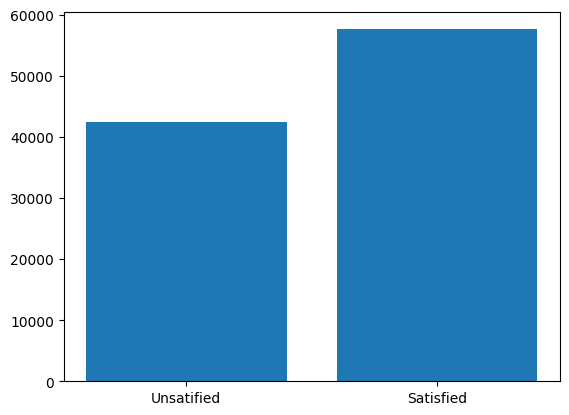

In [29]:
satis = data['Satisfaction'].value_counts().to_numpy()
satis = np.sort(satis)
plt.bar(["Unsatified", "Satisfied"], satis)
plt.plot()

### Simple Pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [31]:
numeric_features = [ "Age", "Income", "Remote Working Days",
                    "Price", "Punctuality", "Duration", "Frequency",
                    "Overcrowding"]
numeric_transformer = Pipeline(
    steps=[("scaler", MinMaxScaler())]
)

categorical_features = ["Has Car", "Gender","First-Class"]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder())
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [33]:
def SimplePipeline(simulator, data_size):
    np.random.seed(1)
    gen = simulator(data_size)
    data = gen.df
    
    X = data.copy().drop(['Satisfaction'], axis=1)
    y = data['Satisfaction']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    def my_pipeline(model, preprocessor):
        clf = Pipeline(
        steps=[("preprocessor", preprocessor),
               ("classifier", model)]
        )
        clf.fit(X_train, y_train)
        return clf.score(X_test, y_test)

    score_random_forest = my_pipeline(RandomForestClassifier(), preprocessor)
    score_logistic = my_pipeline(LogisticRegression(), preprocessor)
    score_perceptron = my_pipeline(Perceptron(), preprocessor)
    score_knn = my_pipeline(KNeighborsClassifier(), preprocessor)
    
    print(f"Simulator = {gen}, Size of data = {data_size}")
    print(f"Accuracy score for Random Forest Classifier: {score_random_forest:.4f}")
    print(f"Accuracy score for Logistic Regression: {score_logistic:.4f}")
    print(f"Accuracy score for Single Layer Perceptron: {score_perceptron:.4f}")
    print(f"Accuracy score for KNeighborsClassifier: {score_knn:.4f}")

    

In [34]:
SimplePipeline(ImpactOnOvercrowding, 10000)

Simulator = ImpactOnOvercrowding, Size of data = 1000
Accuracy score for Random Forest Classifier: 0.5879
Accuracy score for Logistic Regression: 0.5758
Accuracy score for Single Layer Perceptron: 0.4909
Accuracy score for KNeighborsClassifier: 0.5455


### Feature selection

#### Why feature selection ?

Because we need to be certain that the results match the simulation. So we do this principally to check if our the results make sense in regard of the simulation. 

In [9]:
from GenerativeModel import NoIncomeDependentSatisfaction

In [19]:
# Generation of synthetic data
np.random.seed(1)
gen = ImpactOnOvercrowding(100000)
data = gen.df
data['Gender'] = data['Gender'].map({'M': 1, 'F': 0})
data['Has Car'] = data['Has Car'].map({'yes': 1, 'no': 0})
data.head()

,Age,Gender,Income,Remote Working Days,Has Car,First-Class,Price,Punctuality,Duration,Frequency,Overcrowding,Satisfaction
0,44,0,109000,3,0,1,5,4,3,2,1,0
1,58,1,84000,4,1,0,5,5,5,3,1,1
2,47,1,84000,1,1,1,4,3,4,2,1,1
3,20,0,41000,0,1,0,2,4,4,2,3,0
4,18,1,1000,0,1,1,4,5,5,1,1,1


In [20]:
# Filter method
correlations = data.corr()['Satisfaction'].abs().sort_values(ascending=False)

print('correlation:',correlations)

correlation: Satisfaction           1.000000
Frequency              0.173966
Punctuality            0.168323
Overcrowding           0.149394
Has Car                0.064600
First-Class            0.059364
Remote Working Days    0.055792
Duration               0.047817
Income                 0.015371
Price                  0.002519
Age                    0.002429
Gender                 0.001919
Name: Satisfaction, dtype: float64


In [21]:
# RFE
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Define the model using linear regression
model = LogisticRegression()

# Define RFE with the model and specify the number of features to select
rfe = RFE(model, n_features_to_select=5)

# Separate features and target variable
X = data.drop(columns=['Satisfaction'])
y = data['Satisfaction']

scale = MinMaxScaler()
X_minmax = scale.fit_transform(X)
# Fit RFE to the data
rfe.fit(X_minmax, y)

# Get the ranking of features
feature_ranking = pd.DataFrame({
    'feature': X.columns,
    'rank': rfe.ranking_
}).sort_values(by='rank')

print(feature_ranking)

                feature  rank
6                 Price     1
7           Punctuality     1
8              Duration     1
9             Frequency     1
10         Overcrowding     1
5           First-Class     2
3   Remote Working Days     3
2                Income     4
4               Has Car     5
0                   Age     6
1                Gender     7


In [22]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_minmax, y)

# Get feature importances
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importances)

                feature  importance
0                   Age    0.375773
2                Income    0.113730
3   Remote Working Days    0.096170
8              Duration    0.085839
6                 Price    0.069461
9             Frequency    0.069189
7           Punctuality    0.066411
10         Overcrowding    0.055587
1                Gender    0.033601
4               Has Car    0.022674
5           First-Class    0.011566


In [23]:
# comparing the different models

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

scale = MinMaxScaler()
X_train_minmax = scale.fit_transform(X_train)
X_test_minmax = scale.fit_transform(X_test)

# Model without feature selection
model_all_features = LogisticRegression(max_iter=200)
model_all_features.fit(X_train_minmax, y_train)
predictions_all = model_all_features.predict(X_test_minmax)
accuracy_all = accuracy_score(y_test, predictions_all)
print(f'Accuracy without feature selection: {accuracy_all:.6f}')

# Model with selected features (top 5 from RFE)
selected_features = feature_ranking[feature_ranking['rank'] == 1]['feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_minmax = scale.fit_transform(X_train_selected)
X_test_selected_minmax = scale.fit_transform(X_test_selected)

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (RFE): {accuracy_selected:.6f}')

# Model with selected features (correleted filter > 0.4)
X_train_selected = X_train.loc[:,["Price", "Overcrowding"]]
X_test_selected = X_test.loc[:,["Price", "Overcrowding"]]

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (Filter): {accuracy_selected:.6f}')

# Model with selected features (Random Forest)
selected_features = importances[importances['importance'] > 0.1]['feature']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected_minmax = scale.fit_transform(X_train_selected)
X_test_selected_minmax = scale.fit_transform(X_test_selected)

model_selected_features = LogisticRegression(max_iter=200)
model_selected_features.fit(X_train_selected_minmax, y_train)
predictions_selected = model_selected_features.predict(X_test_selected_minmax)
accuracy_selected = accuracy_score(y_test, predictions_selected)

print(f'Accuracy with feature selection (Random Forest): {accuracy_selected:.6f}')

Accuracy without feature selection: 0.624433
Accuracy with feature selection (RFE): 0.625400
Accuracy with feature selection (Filter): 0.625400
Accuracy with feature selection (Random Forest): 0.575233


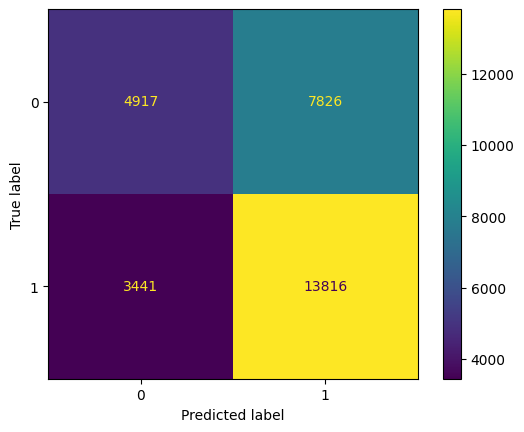

In [24]:
cm = confusion_matrix(y_test, predictions_all, labels=model_all_features.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_all_features.classes_)
disp.plot()
plt.show()

### TODO:
Refaire ce qu'il y a ci-dessous mais pour les autres models également. (si possible)

In [25]:
accuracies = np.zeros(X.shape[1])
for i in range (1, X.shape[1] + 1):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_minmax, y)

    # Get the ranking of features
    feature_ranking = pd.DataFrame({
        'feature': X.columns,
        'rank': rfe.ranking_
    }).sort_values(by='rank')
    # top i from RFE
    selected_features = feature_ranking[feature_ranking['rank'] == 1]['feature']
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    X_train_selected_minmax = scale.fit_transform(X_train_selected)
    X_test_selected_minmax = scale.fit_transform(X_test_selected)

    model_selected_features = LogisticRegression(max_iter=200)
    model_selected_features.fit(X_train_selected_minmax, y_train)
    predictions_selected = model_selected_features.predict(X_test_selected_minmax)
    accuracies[i - 1] = accuracy_score(y_test, predictions_selected)

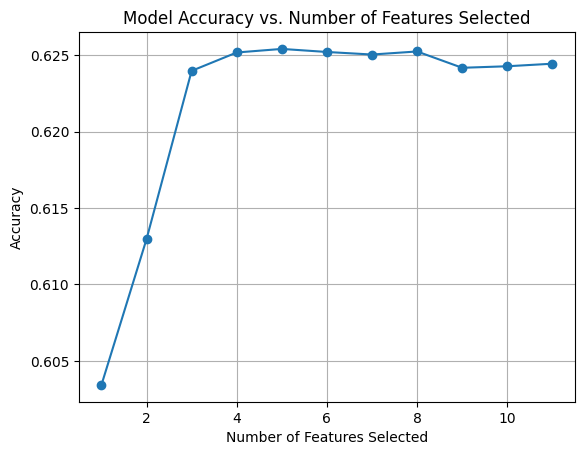

In [26]:
import matplotlib.pyplot as plt
# Plot accuracy vs. number of features
plt.plot(np.arange(1, X.shape[1] + 1), accuracies, marker='o')
plt.xlabel("Number of Features Selected")
plt.ylabel("Accuracy")
plt.title("Model Accuracy vs. Number of Features Selected")
plt.grid()
plt.show()

In [27]:
i = np.argmax(accuracies)
print(f"Max accuracy is {accuracies[i]}, with {i + 1} features selected !")

Max accuracy is 0.6254, with 5 features selected !
